In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-claim-dataset/dev.csv
/kaggle/input/twitter-claim-dataset/new_train.csv
/kaggle/input/twitter-claim-dataset/LESA-claim.csv
/kaggle/input/twitter-claim-dataset/Twitter_filter.csv
/kaggle/input/twitter-claim-dataset/train.csv
/kaggle/input/twitter-claim-dataset/test.csv


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW
from sklearn.model_selection import train_test_split
import pandas as pd
import time as time
import torch.nn.functional as F
import torch.nn as nn
import transformers

import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
import tqdm as tqdm
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

os.environ['TOKENIZERS_PARALLELISM'] = 'false'


from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# cehen44936@shanreto.com


In [4]:
start = time.time()
# Read data
# df_train = pd.read_csv("//kaggle/input/twitter-claim-dataset/new_train.csv")
# df_train = pd.read_csv("//kaggle/input/twitter-claim-dataset/train.csv")
# df_train = df_train.iloc[:3000]

df_train = pd.read_csv("/kaggle/input/twitter-claim-dataset/train.csv")
print(len(df_train))
# df_train = df_train.sample(n=75000, random_state=42)

# Split data into train, validation, test
df_valid = pd.read_csv("//kaggle/input/twitter-claim-dataset/dev.csv")
df_test = pd.read_csv("//kaggle/input/twitter-claim-dataset/test.csv")

if 'claim' not in df_test.columns:
    # Add an empty column named "claim" and fill it with zeros
    df_test['claim'] = 0  # Fill with zeros

# Convert the 'claim' column to integer type
df_test['claim'] = df_test['claim'].astype(int)


# print(f"Train: {df_train.shape},  Valid: {df_valid.shape}")
print(f"Train: {df_train.shape},  Test: {df_test.shape},    Valid: {df_valid.shape}")
print(df_train.head())
# df_train.head()

6986
Train: (6986, 3),  Test: (1498, 3),    Valid: (1497, 3)
     ID                                         tweet_text  claim
0  7568  Coronavirus may have originated in lab linked ...      1
1  2439  @SCMPNews China will buy all shares that's y i...      1
2  9844  I'm curious if the pneumonia vaccine (Prevnar-...      1
3  5007  dear you knew about covid 19 in january it is ...      1
4  8020  Wow, they're as dumb as @realDonaldTrump sugge...      1


In [5]:
a = df_train['claim'].value_counts(normalize = True)
print(type(a))
b = df_valid['claim'].value_counts(normalize = True)
print(a,b)

df_train['claim'].value_counts()
print(a[1],a[0])

<class 'pandas.core.series.Series'>
claim
1    0.874034
0    0.125966
Name: proportion, dtype: float64 claim
1    0.869071
0    0.130929
Name: proportion, dtype: float64
0.8740337818494132 0.1259662181505869


In [6]:
# Hyperparameters
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 20
# LEARNING_RATE = 1e-05
max_words = df_valid['tweet_text'].apply(lambda x: len(x.split())).max()
Model_name = 'bert-base-uncased'
# Model_name = 'xml-roberta-base'

print("Maximum number of words in a tweet:", max_words)

Maximum number of words in a tweet: 80


In [7]:
# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(Model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['tweet_text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
#         title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
#             'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }
print("done")

done


In [10]:
target_list = ['claim'] 

train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [11]:
# !pip install nlpaug

In [12]:
# testing the dataset
print(next(iter(train_dataset)))



{'input_ids': tensor([  101, 21887, 23350,  2089,  2031,  7940,  1999,  6845,  5799,  2000,
         2859,  1005,  1055, 16012,  9028, 17883,  2565,  2798,  2002,  7106,
         1999,  4774,  1997,  1996, 27754,  2387,  3203,  7044, 14368, 13750,
         2010,  2398,  2006,  1996,  3509,  3038,  2054,  2031,  2017,  2589,
         2748,  2149, 12873,  4632,  4286,  2023,  2003, 21746,  2039, 16770,
         1024,  1013,  1013,  1056,  1012,  2522,  1013, 29491,  2480,  2243,
         3501,  2094,  6767,  2487,  2100,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

'import nlpaug.augmenter.char as nac\nimport nlpaug.augmenter.word as naw\nimport nlpaug.augmenter.sentence as nas\nimport nlpaug.flow as nafc\nfrom nlpaug.util import Action\n\ndef augment_dataset(dataset, aug):\n    augmented_data = []\n    for data in dataset:\n        text = data[\'title\']\n        augmented_text = aug.augment(text)\n        data[\'title\'] = augmented_text\n        augmented_data.append(data)\n    return augmented_data\n\n# Initialize augmentation method\naug = naw.ContextualWordEmbsAug(model_path=\'bert-base-uncased\', action="insert")\n\n# Augment train dataset\ntrain_dataset = augment_dataset(train_dataset, aug)\nprint(next(iter(train_dataset)))'

In [13]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=4
)
   

In [14]:
import torch
import torch.nn as nn
from transformers import AutoModel

class BERTClass(torch.nn.Module):
    def __init__(self, num_classes):
        super(BERTClass, self).__init__()
        self.bert_model = AutoModel.from_pretrained(Model_name, return_dict=True)
        
        for param in self.bert_model.parameters():
            param.requires_grad = False
        for param in self.bert_model.encoder.layer[-4:].parameters():
            param.requires_grad = True
        
        # Get the output size of the last layer of the BERT model
        bert_output_size = self.bert_model.config.hidden_size
        print(f'Bert output size:{bert_output_size}')
        self.ffn = nn.Sequential(
            nn.Dropout(0.6),
            nn.Tanh(),
            nn.LayerNorm(bert_output_size),
            nn.Linear(bert_output_size, 128),
            nn.Dropout(0.3),
#             nn.Tanh(),
#             Used 0.3 on last night of 22, size
            nn.LayerNorm(128),
            nn.Linear(128, num_classes)
#             nn.Sigmoid()
        )


    def forward(self, input_ids, attn_mask):
        # BERT base model output
        output = self.bert_model(input_ids, attention_mask=attn_mask)
        output_dropout = output[1]
#         output_dropout = self.dropout(output.pooler_output)
        
        output = self.ffn(output_dropout)
        
        return output



In [15]:
# Define your class weights tensor
class_weights_ratio = a[0]/a[1]
class_weights_tensor = torch.FloatTensor([class_weights_ratio]).to(device)
print(class_weights_ratio)
sigmoid_value = class_weights_ratio
# Define your loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
# Binary Cross Entropy with Logits Loss for multi-label classification

# criterion = nn.BCEWithLogitsLoss()

0.14412053717654766


In [16]:
def loss_fn(outputs, targets):
#     return torch.nn.BCEWithLogitsLoss(weight=class_weights)(outputs, targets)
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [17]:
def train_model(training_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    check = 1
    # set model to training mode
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)

        targets = data['targets'].to(device, dtype=torch.float)

        # forward
        outputs = model(ids, mask)
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        
        # calculate training accuracy
        predictions = (torch.sigmoid(outputs) > sigmoid_value).float()  # apply threshold
#         predictions = (outputs > 0.7).float()  # apply threshold
        correct_predictions += torch.sum(predictions == targets).item()
        num_samples += targets.size(0)
        '''if check:
            print(f'Outputs\n{outputs}\nTargets\n{targets}\nPredictions{predictions}')
            check = 0'''
        '''# print gradients before backward pass
        print("Gradients before backward pass:")
        for name, param in model.named_parameters():
            print(name, param.grad)'''

        # backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        '''# print gradients after backward pass
        print("Gradients after backward pass:")
        for name, param in model.named_parameters():
            print(name, param.grad)'''

        optimizer.step()

        '''if scheduler is not None:
            scheduler.step(loss)  # Step with loss'''

        # Update progress bar
        # loop.set_description(f"Epoch [{epoch}/{EPOCHS}]")
        # loop.set_postfix(batch_loss=loss.item())

    # Calculate overall accuracy
    overall_accuracy = correct_predictions / num_samples

    # return trained model, model accuracy, mean loss
    return model, overall_accuracy, np.mean(losses)

In [18]:
def eval_model(validation_loader, model):
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_targets = []
    all_predictions = []
    # set model to evaluation mode
    model.eval()
    with torch.no_grad():
        for data in validation_loader:
            ids = data['input_ids'].to(device)
            mask = data['attention_mask'].to(device)
#             token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)
            outputs = model(ids, mask)

            loss = criterion(outputs, targets)
            losses.append(loss.item())
            # calculate validation accuracy
            predictions = (torch.sigmoid(outputs) > sigmoid_value).float()  # apply threshold
#             predictions = (outputs > 0.7).float()  # apply threshold
            correct_predictions += torch.sum(predictions == targets).item()
            num_samples += targets.size(0)
            
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
    
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    valid_report = classification_report(np.array(all_targets),np.array(all_predictions),output_dict = True, zero_division = 0)
    print(f'For Validation :{ classification_report(np.array(all_targets),np.array(all_predictions),output_dict = False, zero_division = 0)}')
    print(f'Accuracy: {np.round(accuracy_score(all_targets, all_predictions),4)},\n \
    Precision: {np.round(precision_score(all_targets, all_predictions),4)},\n \
    Recall: {np.round(recall_score(all_targets, all_predictions),4)},\n \
    F1 Score: {np.round(f1_score(all_targets, all_predictions),4)},\n \
    Macro F1: {np.round(f1_score(all_targets, all_predictions, average="macro"),4)}')
    overall_accuracy = correct_predictions / num_samples
    macro_f1 = f1_score(all_targets, all_predictions, average="macro")
    print(all_predictions[5])
    return macro_f1, overall_accuracy, np.mean(losses)

In [19]:
   
if 'model' in locals():
    del model
    
# Instantiate the model with the correct number of classes
num_classes = len(target_list)
model = BERTClass(num_classes)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Bert output size:768


In [20]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []
macro_f1s = []
# Move model to device
model.to(device)
best_f1 = 0
best_accuracy = 0
# EPOCHS = 5

initial_lr = 1e-5

# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    macro_f1, val_acc, val_loss = eval_model(val_data_loader, model)
    
    # Learning rate scheduler step
#     scheduler.step(val_loss)
#     print(f'Learning Rate: {scheduler._last_lr[0]}')

    train_accs.append(train_acc)
    train_losses.append(train_loss)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    macro_f1s.append(macro_f1)
    if epoch < 8:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.8
    
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "best_model_state.bin")
        best_accuracy = val_acc
    
    
    torch.save(model.state_dict(), "best_f1_model.bin")
    
    print(f'Train_loss{train_loss},Val Loss{val_loss},Train_acc{train_acc},Val_acc{val_acc}')

Epoch 1/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       1.00      0.01      0.01       196
         1.0       0.87      1.00      0.93      1301

    accuracy                           0.87      1497
   macro avg       0.93      0.50      0.47      1497
weighted avg       0.89      0.87      0.81      1497

Accuracy: 0.8697,
     Precision: 0.8697,
     Recall: 1.0,
     F1 Score: 0.9303,
     Macro F1: 0.4702
[1.]
Train_loss0.17882289825267322,Val Loss0.17672952403254966,Train_acc0.87374749498998,Val_acc0.8697394789579158
Epoch 2/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.71      0.17      0.28       196
         1.0       0.89      0.99      0.94      1301

    accuracy                           0.88      1497
   macro avg       0.80      0.58      0.61      1497
weighted avg       0.86      0.88      0.85      1497

Accuracy: 0.8824,
     Precision: 0.8882,
     Recall: 0.9892,
     F1 Score: 0.936,
     Macro F1: 0.6073
[1.]
Train_loss0.16129497731918602,Val Loss0.1772260732671365,Train_acc0.8734612081305468,Val_acc0.8824315297261189
Epoch 3/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.58      0.36      0.45       196
         1.0       0.91      0.96      0.93      1301

    accuracy                           0.88      1497
   macro avg       0.74      0.66      0.69      1497
weighted avg       0.87      0.88      0.87      1497

Accuracy: 0.8818,
     Precision: 0.909,
     Recall: 0.96,
     F1 Score: 0.9338,
     Macro F1: 0.6895
[1.]
Train_loss0.14993984257755483,Val Loss0.16388731463713216,Train_acc0.8803320927569425,Val_acc0.8817635270541082
Epoch 4/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50       196
         1.0       0.92      0.92      0.92      1301

    accuracy                           0.87      1497
   macro avg       0.71      0.71      0.71      1497
weighted avg       0.87      0.87      0.87      1497

Accuracy: 0.8691,
     Precision: 0.9247,
     Recall: 0.9247,
     F1 Score: 0.9247,
     Macro F1: 0.7123
[1.]
Train_loss0.14012689550047064,Val Loss0.1657264672734953,Train_acc0.887918694531921,Val_acc0.8690714762859052
Epoch 5/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.59      0.33      0.42       196
         1.0       0.90      0.97      0.93      1301

    accuracy                           0.88      1497
   macro avg       0.75      0.65      0.68      1497
weighted avg       0.86      0.88      0.87      1497

Accuracy: 0.8818,
     Precision: 0.9049,
     Recall: 0.9654,
     F1 Score: 0.9342,
     Macro F1: 0.6769
[1.]
Train_loss0.13325330660863857,Val Loss0.1844322349123181,Train_acc0.8890638419696536,Val_acc0.8817635270541082
Epoch 6/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.54      0.47      0.50       196
         1.0       0.92      0.94      0.93      1301

    accuracy                           0.88      1497
   macro avg       0.73      0.71      0.72      1497
weighted avg       0.87      0.88      0.87      1497

Accuracy: 0.8778,
     Precision: 0.9222,
     Recall: 0.9385,
     F1 Score: 0.9303,
     Macro F1: 0.7172
[1.]
Train_loss0.13009056516707762,Val Loss0.1873604764745749,Train_acc0.8942170054394504,Val_acc0.8777555110220441
Epoch 7/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.52      0.48      0.50       196
         1.0       0.92      0.93      0.93      1301

    accuracy                           0.87      1497
   macro avg       0.72      0.71      0.71      1497
weighted avg       0.87      0.87      0.87      1497

Accuracy: 0.8744,
     Precision: 0.9226,
     Recall: 0.9339,
     F1 Score: 0.9282,
     Macro F1: 0.7141
[1.]
Train_loss0.1243100763518082,Val Loss0.1794808313617126,Train_acc0.8999427426281134,Val_acc0.8744154976619907
Epoch 8/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.60      0.39      0.47       196
         1.0       0.91      0.96      0.94      1301

    accuracy                           0.89      1497
   macro avg       0.76      0.67      0.70      1497
weighted avg       0.87      0.89      0.88      1497

Accuracy: 0.8858,
     Precision: 0.9124,
     Recall: 0.9608,
     F1 Score: 0.936,
     Macro F1: 0.7033
[1.]
Train_loss0.11987399219085614,Val Loss0.21014840200919896,Train_acc0.8997995991983968,Val_acc0.8857715430861723
Epoch 9/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.61      0.38      0.47       196
         1.0       0.91      0.96      0.94      1301

    accuracy                           0.89      1497
   macro avg       0.76      0.67      0.70      1497
weighted avg       0.87      0.89      0.88      1497

Accuracy: 0.8871,
     Precision: 0.9113,
     Recall: 0.9639,
     F1 Score: 0.9369,
     Macro F1: 0.7019
[1.]
Train_loss0.1209355546118909,Val Loss0.21023076756342135,Train_acc0.9042370455196107,Val_acc0.8871075484301937
Epoch 10/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.59      0.42      0.49       196
         1.0       0.92      0.96      0.94      1301

    accuracy                           0.89      1497
   macro avg       0.75      0.69      0.71      1497
weighted avg       0.87      0.89      0.88      1497

Accuracy: 0.8858,
     Precision: 0.9161,
     Recall: 0.9562,
     F1 Score: 0.9357,
     Macro F1: 0.7126
[1.]
Train_loss0.11487376881290219,Val Loss0.20747033643357932,Train_acc0.9035213283710277,Val_acc0.8857715430861723
Epoch 11/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.58      0.42      0.49       196
         1.0       0.92      0.95      0.93      1301

    accuracy                           0.88      1497
   macro avg       0.75      0.69      0.71      1497
weighted avg       0.87      0.88      0.88      1497

Accuracy: 0.8838,
     Precision: 0.9165,
     Recall: 0.9531,
     F1 Score: 0.9344,
     Macro F1: 0.7113
[1.]
Train_loss0.11488035640698481,Val Loss0.20556039376025823,Train_acc0.9082450615516747,Val_acc0.8837675350701403
Epoch 12/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.53      0.46      0.49       196
         1.0       0.92      0.94      0.93      1301

    accuracy                           0.88      1497
   macro avg       0.72      0.70      0.71      1497
weighted avg       0.87      0.88      0.87      1497

Accuracy: 0.8751,
     Precision: 0.9201,
     Recall: 0.9377,
     F1 Score: 0.9288,
     Macro F1: 0.7096
[1.]
Train_loss0.11046939922893075,Val Loss0.20228751873141748,Train_acc0.9116805038648726,Val_acc0.8750835003340013
Epoch 13/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.53      0.46      0.50       196
         1.0       0.92      0.94      0.93      1301

    accuracy                           0.88      1497
   macro avg       0.73      0.70      0.71      1497
weighted avg       0.87      0.88      0.87      1497

Accuracy: 0.8764,
     Precision: 0.9208,
     Recall: 0.9385,
     F1 Score: 0.9296,
     Macro F1: 0.7127
[1.]
Train_loss0.10732383236237876,Val Loss0.21429702272995355,Train_acc0.9126825078728886,Val_acc0.8764195056780227
Epoch 14/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.54      0.47      0.50       196
         1.0       0.92      0.94      0.93      1301

    accuracy                           0.88      1497
   macro avg       0.73      0.70      0.72      1497
weighted avg       0.87      0.88      0.87      1497

Accuracy: 0.8778,
     Precision: 0.9216,
     Recall: 0.9393,
     F1 Score: 0.9303,
     Macro F1: 0.7159
[1.]
Train_loss0.10503943703079796,Val Loss0.21473620999901694,Train_acc0.9156885198969368,Val_acc0.8777555110220441
Epoch 15/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.54      0.45      0.49       196
         1.0       0.92      0.94      0.93      1301

    accuracy                           0.88      1497
   macro avg       0.73      0.70      0.71      1497
weighted avg       0.87      0.88      0.87      1497

Accuracy: 0.8778,
     Precision: 0.9197,
     Recall: 0.9416,
     F1 Score: 0.9305,
     Macro F1: 0.7118
[1.]
Train_loss0.1028098269329498,Val Loss0.2155270157802969,Train_acc0.9151159461780705,Val_acc0.8777555110220441
Epoch 16/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.57      0.39      0.47       196
         1.0       0.91      0.96      0.93      1301

    accuracy                           0.88      1497
   macro avg       0.74      0.67      0.70      1497
weighted avg       0.87      0.88      0.87      1497

Accuracy: 0.8824,
     Precision: 0.9127,
     Recall: 0.9562,
     F1 Score: 0.9339,
     Macro F1: 0.7003
[1.]
Train_loss0.09801419845247296,Val Loss0.25342916457993075,Train_acc0.9192671056398511,Val_acc0.8824315297261189
Epoch 17/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.61      0.39      0.48       196
         1.0       0.91      0.96      0.94      1301

    accuracy                           0.89      1497
   macro avg       0.76      0.68      0.71      1497
weighted avg       0.87      0.89      0.88      1497

Accuracy: 0.8878,
     Precision: 0.9132,
     Recall: 0.9623,
     F1 Score: 0.9371,
     Macro F1: 0.7077
[1.]
Train_loss0.09705514118961939,Val Loss0.2634256432362971,Train_acc0.9191239622101346,Val_acc0.8877755511022044
Epoch 18/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.54      0.44      0.49       196
         1.0       0.92      0.94      0.93      1301

    accuracy                           0.88      1497
   macro avg       0.73      0.69      0.71      1497
weighted avg       0.87      0.88      0.87      1497

Accuracy: 0.8784,
     Precision: 0.9178,
     Recall: 0.9447,
     F1 Score: 0.9311,
     Macro F1: 0.7085
[1.]
Train_loss0.09358041875652577,Val Loss0.24823419807944447,Train_acc0.9222731176638992,Val_acc0.8784235136940548
Epoch 19/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.54      0.44      0.49       196
         1.0       0.92      0.94      0.93      1301

    accuracy                           0.88      1497
   macro avg       0.73      0.69      0.71      1497
weighted avg       0.87      0.88      0.87      1497

Accuracy: 0.8784,
     Precision: 0.9185,
     Recall: 0.9439,
     F1 Score: 0.931,
     Macro F1: 0.7099
[1.]
Train_loss0.09121775670292483,Val Loss0.2564184218446942,Train_acc0.9271399942742629,Val_acc0.8784235136940548
Epoch 20/20


  0%|          | 0/437 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

         0.0       0.52      0.45      0.48       196
         1.0       0.92      0.94      0.93      1301

    accuracy                           0.87      1497
   macro avg       0.72      0.70      0.71      1497
weighted avg       0.87      0.87      0.87      1497

Accuracy: 0.8731,
     Precision: 0.9192,
     Recall: 0.9362,
     F1 Score: 0.9276,
     Macro F1: 0.7057
[1.]
Train_loss0.09054781628657534,Val Loss0.24420698436640917,Train_acc0.9291440022902949,Val_acc0.8730794923179692


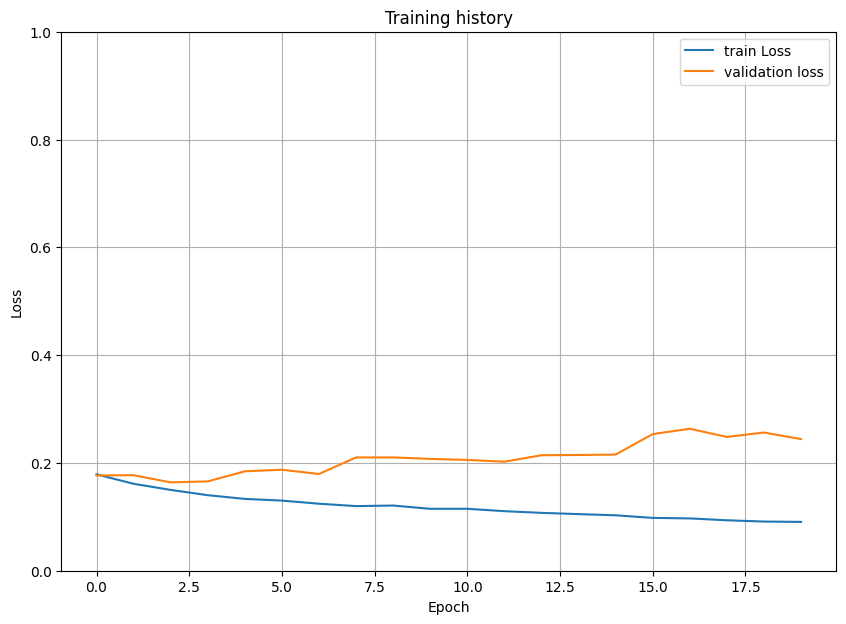

In [21]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(train_losses, label='train Loss')
plt.plot(val_losses, label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()
plt.savefig("Acc vs epochs")

0.8730794923179692 0.9291440022902949


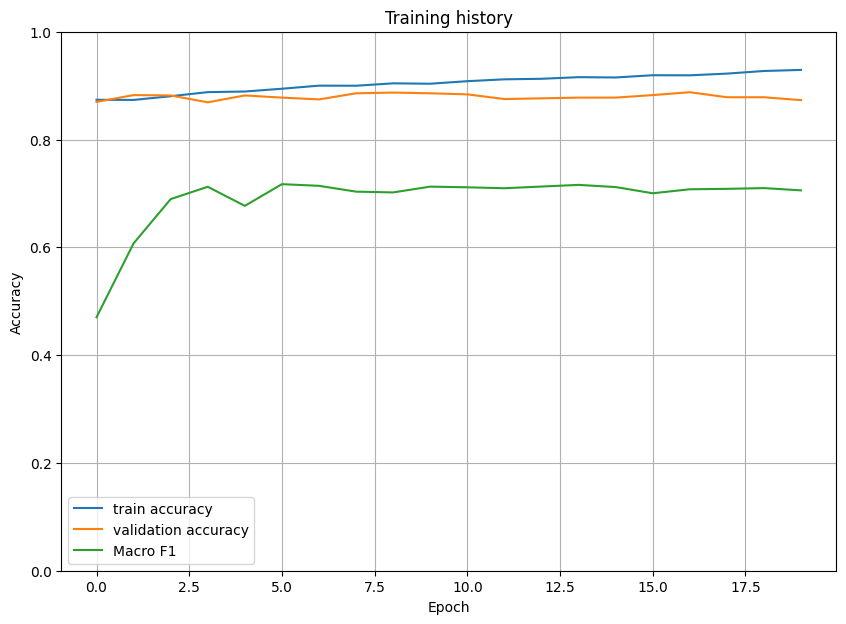

In [ ]:
print(val_acc,train_acc)

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(train_accs, label='train accuracy')
plt.plot(val_accs, label='validation accuracy')
plt.plot(macro_f1s, label='Macro F1')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()
plt.savefig("Metrics vs epochs")

In [23]:
# Loading pretrained model
model = BERTClass(num_classes)
model.load_state_dict(torch.load("/kaggle/working/best_model_state.bin"))
model = model.to(device)

Bert output size:768


In [24]:
macro_f1, val_acc, val_loss = eval_model(val_data_loader, model)
print(f'Validation\:n Macro_F1: {macro_f1},Validaiton Acc: {val_acc} ')

For Validation :              precision    recall  f1-score   support

         0.0       0.61      0.39      0.48       196
         1.0       0.91      0.96      0.94      1301

    accuracy                           0.89      1497
   macro avg       0.76      0.68      0.71      1497
weighted avg       0.87      0.89      0.88      1497

Accuracy: 0.8878,
     Precision: 0.9132,
     Recall: 0.9623,
     F1 Score: 0.9371,
     Macro F1: 0.7077
[1.]
Validation\:n Macro_F1: 0.7076933090341058,Validaiton Acc: 0.8877755511022044 


In [25]:
def test_model(test_loader, model):
    all_predictions = []
    # set model to evaluation mode
    model.eval()
    with torch.no_grad():
        print(test_loader)
        for data in test_loader:
            ids = data['input_ids'].to(device)
            mask = data['attention_mask'].to(device)
            targets = data['targets'].to(device)
            outputs = model(ids, mask)

            # calculate test predictions
            predictions = (torch.sigmoid(outputs) > sigmoid_value).float()  # apply threshold
#             predictions = (outputs > 0.7).float()  # apply threshold
            all_predictions.append(predictions.cpu().numpy())
    
    all_predictions = np.concatenate(all_predictions)
    
    return all_predictions


start = time.time()
# Assuming test_loader is your test data loader and model is your pre-trained model
predictions = test_model(test_data_loader, model)

# Fill the 'claim' column in df_test with predictions
df_test['claim'] = predictions.astype(int)

# Save df_test to "pred_test.csv"
# df_test.to_csv("pred_test.csv", index=False)

df_save = df_test[['ID','claim']]

import datetime

# Get current date and time
now = datetime.datetime.now()

# Format current date and time as dd_XX:XX
date_time = now.strftime("%d_%H:%M")

# Save df_test to a CSV file with current date and time in the file name
file_name = "pred_test_"+date_time+".csv"
df_save.to_csv(file_name, index=False)

print(f"Saved predictions to {file_name}")

Saved predictions to pred_test_07_16:37.csv
